In [ ]:
# Step 1: Import libraries
import pandas as pd

# Step 2: Load the CSV file
df = pd.read_csv("/content/fake_sentiment_data.csv")

# Step 3: Quick look at the data
print("Data sample:")
print(df.head())

print("\nData info:")
print(df.info())

print("\nRating distribution:")
print(df['rating'].value_counts().sort_index())

# Step 4: Simple text preprocessing example (optional)
import re

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_comment'] = df['comment'].apply(clean_text)

print("\nCleaned text sample:")
print(df[['comment', 'clean_comment']].head())


Data sample:
                 name     location                               comment  \
0  Christina Woodward    East Jeff  Average experience, could be better.   
1      James Anderson  North Brian            Neutral feelings about it.   
2     Samantha Snyder   Martinstad     Not bad but room for improvement.   
3       Jordan Garcia   Lake Katie  Average experience, could be better.   
4      Natalie Finley  Port Alyssa            Neutral feelings about it.   

   rating  
0       3  
1       2  
2       3  
3       2  
4       3  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      10000 non-null  object
 1   location  10000 non-null  object
 2   comment   10000 non-null  object
 3   rating    10000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 312.6+ KB
None

Rating distribution:
rating
0    1667
1    1664
2    

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [ ]:
df = pd.read_csv("/content/fake_sentiment_data.csv")

# Label sentiment
def label_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['rating'].apply(label_sentiment)
df['comment'] = df['comment'].astype(str)  # Ensure string

print(df[['comment', 'sentiment']].head())


                                comment sentiment
0  Average experience, could be better.   neutral
1            Neutral feelings about it.  negative
2     Not bad but room for improvement.   neutral
3  Average experience, could be better.  negative
4            Neutral feelings about it.   neutral


In [ ]:
# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])  # negative=0, neutral=1, positive=2

# Tokenize and pad
MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['comment'])

sequences = tokenizer.texts_to_sequences(df['comment'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['label'], test_size=0.2, random_state=42, stratify=df['label']
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

# Step 1: Compute class weights for imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Step 2: Define a better model
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 3: Add EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 4: Train with class weights and early stopping
history = model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_test, y_test),
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 374ms/step - accuracy: 0.6711 - loss: 0.6339 - val_accuracy: 0.8245 - val_loss: 0.2978
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 253ms/step - accuracy: 0.8346 - loss: 0.2641 - val_accuracy: 0.8245 - val_loss: 0.3237
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 266ms/step - accuracy: 0.8291 - loss: 0.2585 - val_accuracy: 0.8245 - val_loss: 0.2686
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - accuracy: 0.8349 - loss: 0.2542 - val_accuracy: 0.8245 - val_loss: 0.2859
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 272ms/step - accuracy: 0.8353 - loss: 0.2518 - val_accuracy: 0.8245 - val_loss: 0.2875
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 253ms/step - accuracy: 0.8381 - loss: 0.2483 - val_accuracy: 0.8245 - val_loss: 0.2862


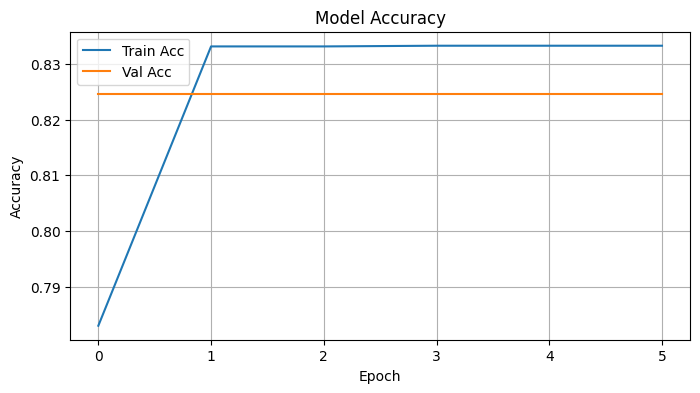

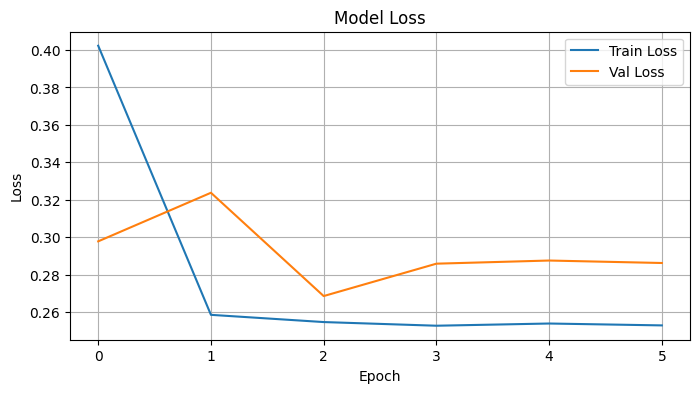

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-24-709613005.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


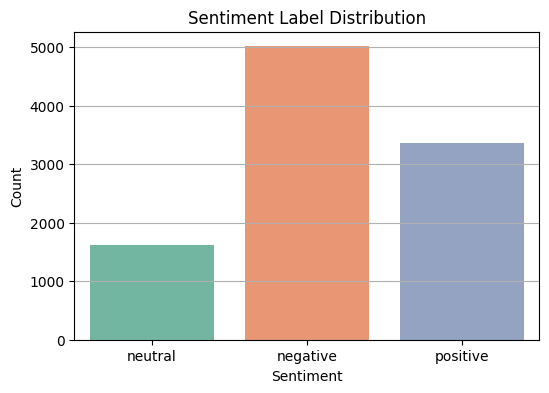

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step


<Figure size 600x400 with 0 Axes>

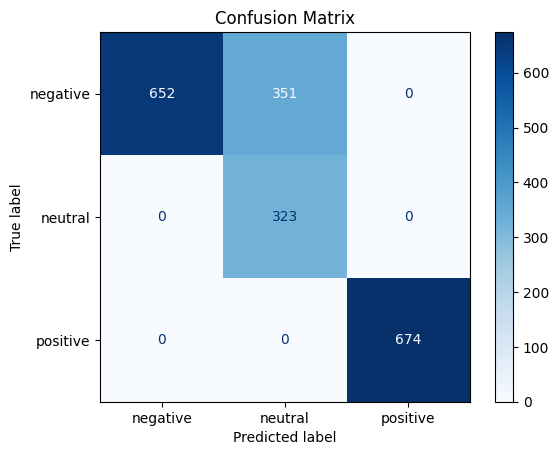

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


/tmp/ipython-input-27-1893088400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(terms), palette='viridis')


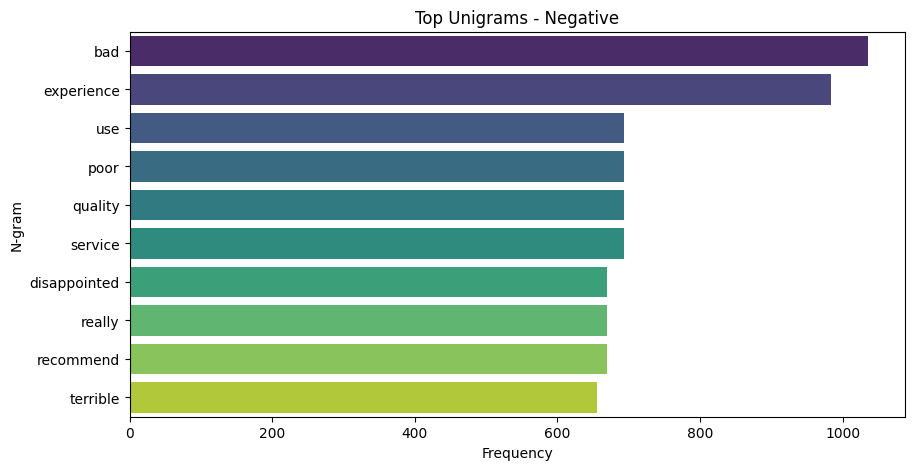

/tmp/ipython-input-27-1893088400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(terms), palette='viridis')


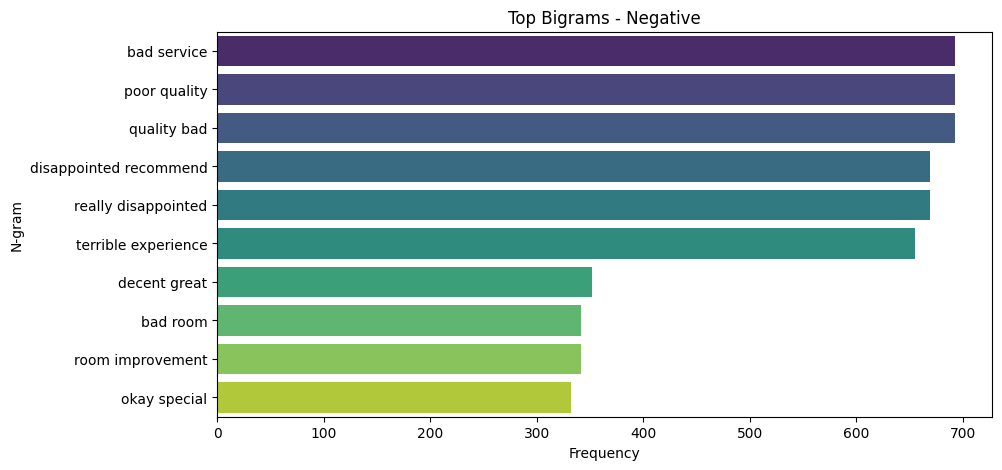

/tmp/ipython-input-27-1893088400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(terms), palette='viridis')


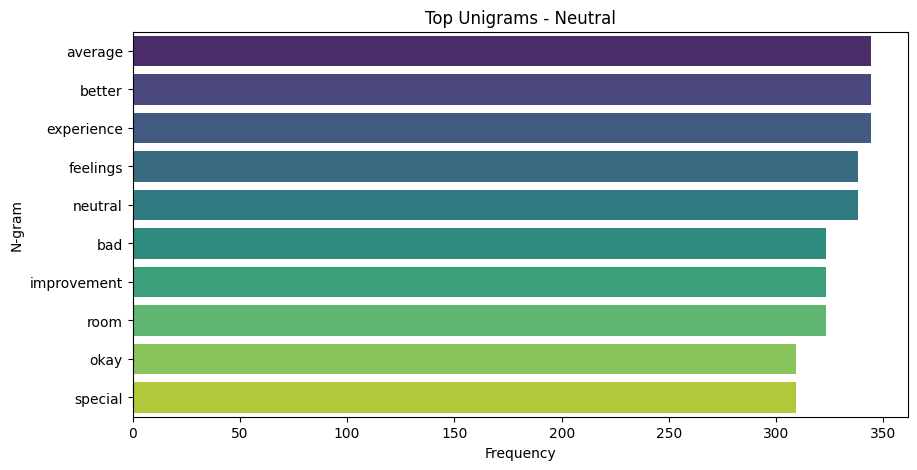

/tmp/ipython-input-27-1893088400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(terms), palette='viridis')


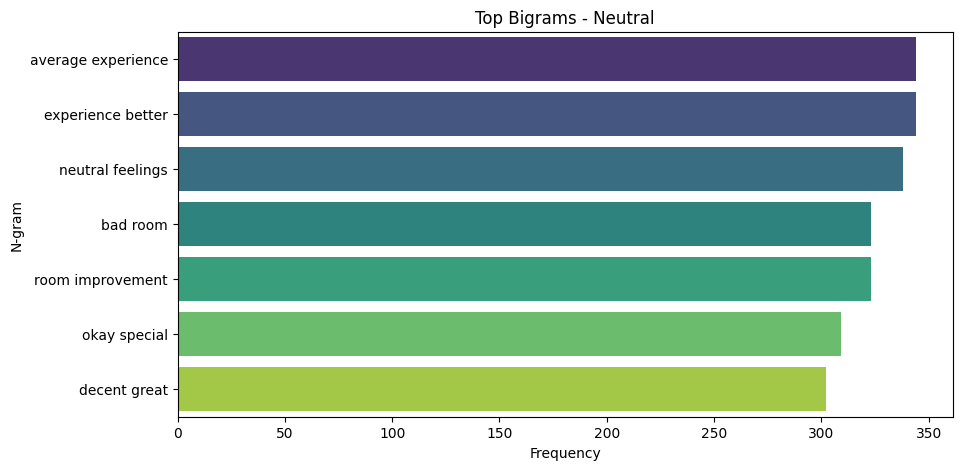

/tmp/ipython-input-27-1893088400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(terms), palette='viridis')


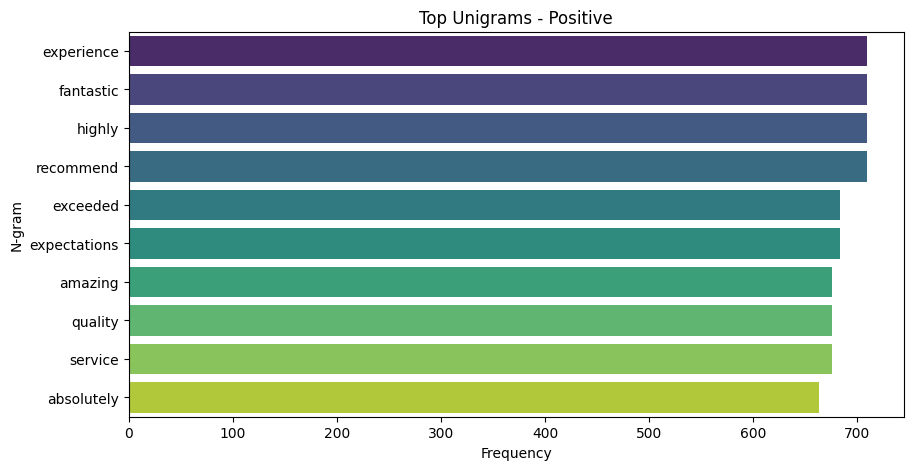

/tmp/ipython-input-27-1893088400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(terms), palette='viridis')


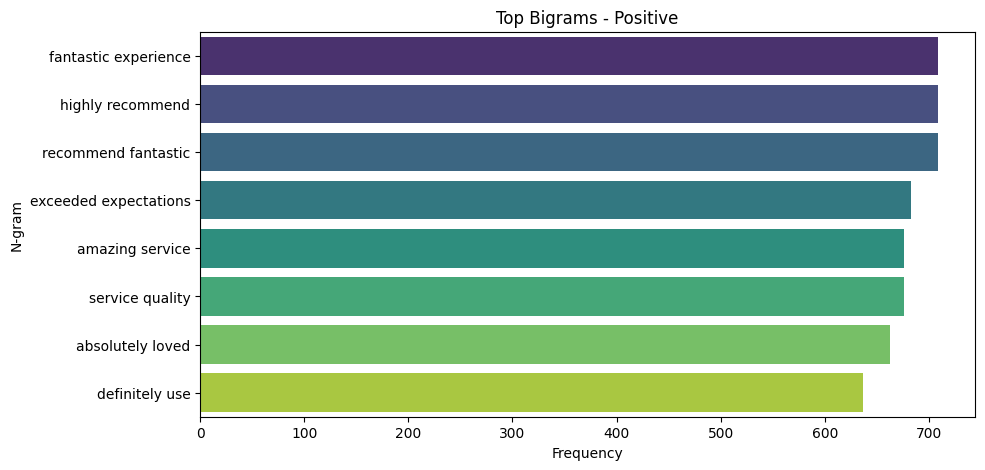

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, n=10, ngram_range=(1,1), title='Top N-grams'):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    sums = X.sum(axis=0)
    terms = vectorizer.get_feature_names_out()
    freqs = [(term, sums[0, idx]) for idx, term in enumerate(terms)]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:n]

    terms, counts = zip(*freqs)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(terms), palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.show()

for sentiment in ['negative', 'neutral', 'positive']:
    corpus = df[df['sentiment'] == sentiment]['comment']
    plot_top_ngrams(corpus, n=10, ngram_range=(1,1), title=f'Top Unigrams - {sentiment.capitalize()}')
    plot_top_ngrams(corpus, n=10, ngram_range=(2,2), title=f'Top Bigrams - {sentiment.capitalize()}')


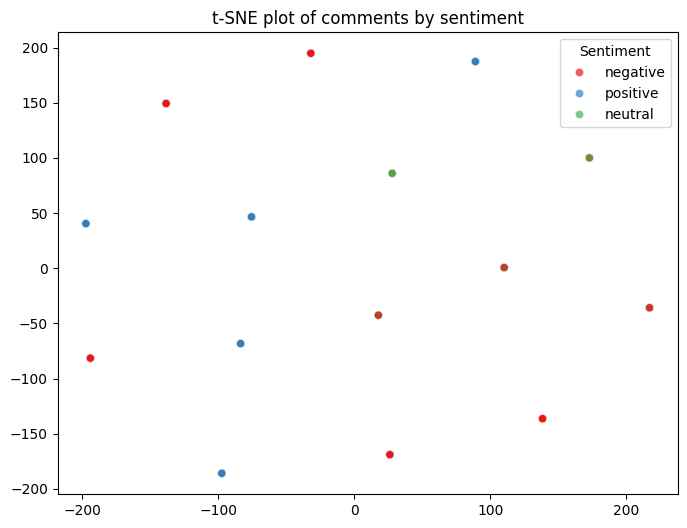

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use your TF-IDF matrix or padded sequences (if sparse, convert to dense)
X_embed = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Reduce dimensions with PCA first for speed
pca = PCA(n_components=50, random_state=42).fit_transform(X_embed)
tsne = TSNE(n_components=2, random_state=42).fit_transform(pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=le.inverse_transform(y_test), palette='Set1', alpha=0.7)
plt.title('t-SNE plot of comments by sentiment')
plt.legend(title='Sentiment')
plt.show()


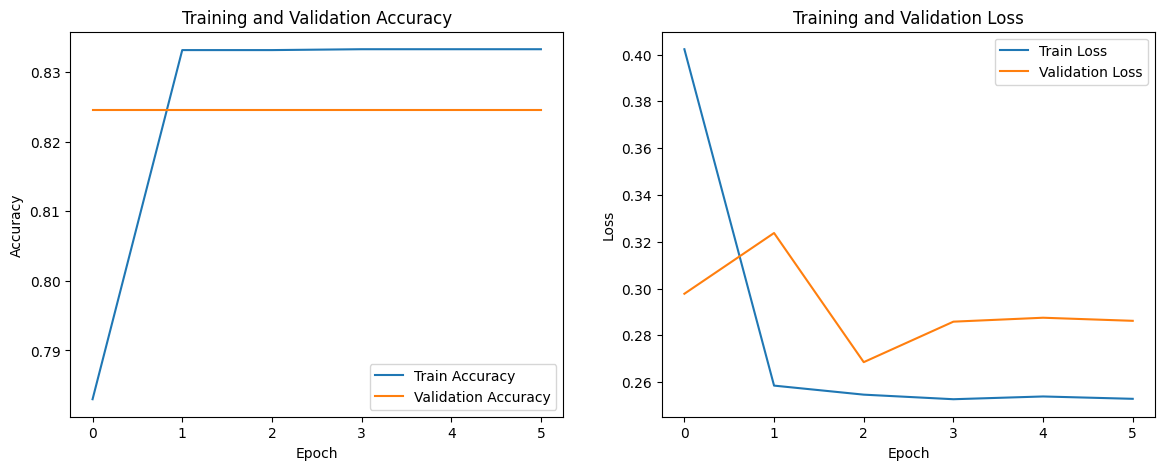

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

plot_training_history(history)


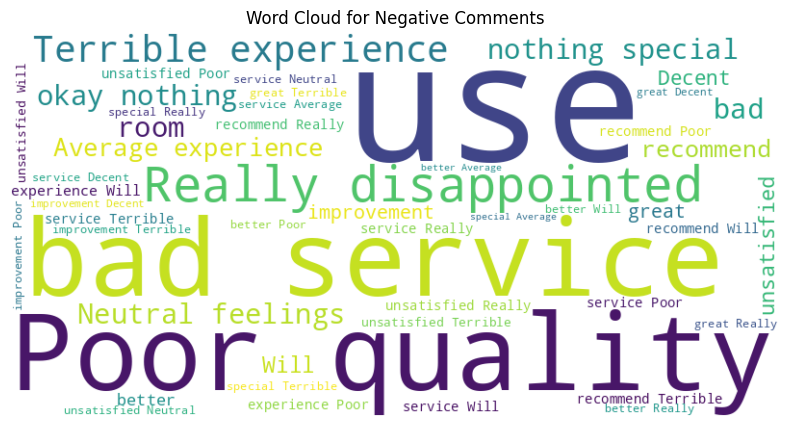

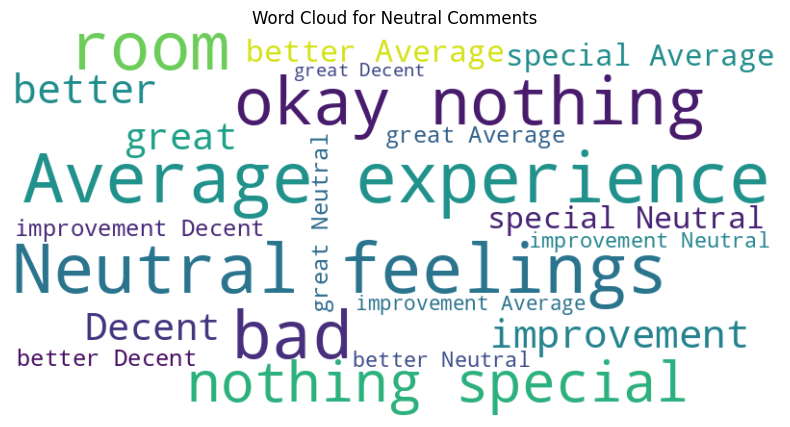

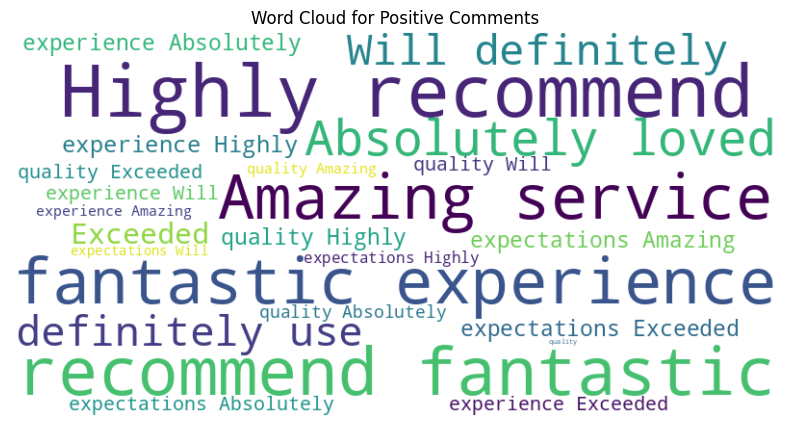

In [ ]:
from wordcloud import WordCloud

for sentiment in le.classes_:
    text = " ".join(df[df['sentiment'] == sentiment]['comment'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Comments")
    plt.axis('off')
    plt.show()
